In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install packages (run this separately first)
!pip install lightgbm fairlearn --quiet

In [3]:
# Imports
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
from fairlearn.metrics import MetricFrame, mean_prediction
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load dataset
file_path = '/content/drive/MyDrive/glassdoor_jobs.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Split into known and missing salaries
df_known = df[df['salary_estimate'] != '-1'].copy()
df_missing = df[df['salary_estimate'] == '-1'].copy()

In [5]:
df_missing.head()

,unnamed:_0,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors
24,24,Data Scientist,-1,JOB CATEGORY:\n\nInformation Services\n\nREQUI...,3.9,Mars\n3.9,Oregon,"Mc Lean, VA",10000+ employees,1911,Company - Private,Food & Beverage Manufacturing,Manufacturing,$10+ billion (USD),-1
42,42,Data Scientist,-1,Take your career to new heights working with a...,4.1,Amount\n4.1,"Chicago, IL","Chicago, IL",201 to 500 employees,2015,Company - Private,Enterprise Software & Network Solutions,Information Technology,Unknown / Non-Applicable,-1
47,47,Data Science Analyst,-1,Company Overview:\n\nBrightside is an employee...,5.0,Brightside\n5.0,"Chandler, AZ","San Francisco, CA",51 to 200 employees,2017,Company - Private,Investment Banking & Asset Management,Finance,Unknown / Non-Applicable,-1
53,53,Data Engineer,-1,"Data Engineer\n£50,000 – £70,000 See Advert\n\...",4.5,Anson McCade\n4.5,"Kingdom, IL","London, United Kingdom",51 to 200 employees,2000,Company - Private,Staffing & Outsourcing,Business Services,$1 to $5 million (USD),-1
64,64,Business Intelligence Analyst,-1,Business Intelligence Analyst\nAccounting\n50 ...,3.1,Amica Mutual\n3.1,"Lincoln, RI","Lincoln, RI",1001 to 5000 employees,1907,Company - Private,Insurance Carriers,Insurance,$1 to $2 billion (USD),-1


In [6]:
df_missing_cleaned = df_missing.drop(columns=['unnamed:_0', 'competitors', 'revenue'], errors='ignore').reset_index(drop=True)
df_missing_cleaned.head()

,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,founded,type_of_ownership,industry,sector
0,Data Scientist,-1,JOB CATEGORY:\n\nInformation Services\n\nREQUI...,3.9,Mars\n3.9,Oregon,"Mc Lean, VA",10000+ employees,1911,Company - Private,Food & Beverage Manufacturing,Manufacturing
1,Data Scientist,-1,Take your career to new heights working with a...,4.1,Amount\n4.1,"Chicago, IL","Chicago, IL",201 to 500 employees,2015,Company - Private,Enterprise Software & Network Solutions,Information Technology
2,Data Science Analyst,-1,Company Overview:\n\nBrightside is an employee...,5.0,Brightside\n5.0,"Chandler, AZ","San Francisco, CA",51 to 200 employees,2017,Company - Private,Investment Banking & Asset Management,Finance
3,Data Engineer,-1,"Data Engineer\n£50,000 – £70,000 See Advert\n\...",4.5,Anson McCade\n4.5,"Kingdom, IL","London, United Kingdom",51 to 200 employees,2000,Company - Private,Staffing & Outsourcing,Business Services
4,Business Intelligence Analyst,-1,Business Intelligence Analyst\nAccounting\n50 ...,3.1,Amica Mutual\n3.1,"Lincoln, RI","Lincoln, RI",1001 to 5000 employees,1907,Company - Private,Insurance Carriers,Insurance


In [7]:
df_known.head()

,unnamed:_0,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [8]:
# Extract salary ranges
df_known['salary_range'] = df_known['salary_estimate'].apply(lambda x: re.findall(r'\$?(\d+)[kK]?', x))
df_known['min_salary'] = df_known['salary_range'].apply(lambda x: int(x[0])*1000 if len(x) > 0 else np.nan)
df_known['max_salary'] = df_known['salary_range'].apply(lambda x: int(x[1])*1000 if len(x) > 1 else np.nan)
df_known['avg_salary'] = df_known[['min_salary', 'max_salary']].mean(axis=1)

# Combine
df_combined = pd.concat([df_known, df_missing], ignore_index=True)
df_combined['was_missing'] = df_combined['salary_estimate'] == '-1'

In [9]:
df_combined.head()

,unnamed:_0,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,salary_range,min_salary,max_salary,avg_salary,was_missing
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,"[53, 91]",53000.0,91000.0,72000.0,False
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,"[63, 112]",63000.0,112000.0,87500.0,False
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,"[80, 90]",80000.0,90000.0,85000.0,False
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...","[56, 97]",56000.0,97000.0,76500.0,False
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee","[86, 143]",86000.0,143000.0,114500.0,False


In [10]:
# Feature Engineering
df_combined['seniority'] = df_combined['job_title'].str.extract(r'(junior|mid|senior|lead|principal)', flags=re.IGNORECASE)
df_combined['seniority'] = df_combined['seniority'].fillna('unknown').str.lower()
#df_combined[['job_city', 'job_state']] = df_combined['location'].str.extract(r'^(.*),\s*([A-Z]{2})$')
df_combined['posting_age'] = df_combined['job_description'].str.extract(r'(\d+)\+?\s*(?=day|month|week|year)', flags=re.IGNORECASE)
df_combined['posting_age'] = pd.to_numeric(df_combined['posting_age'][0], errors='coerce')
df_combined['posting_age'] = df_combined['posting_age'].fillna(df_combined['posting_age'].median())


# Extract city and state from location if format is "City, ST"
df_combined[['job_city', 'job_state']] = df_combined['location'].str.extract(r'^(.*),\s*([A-Z]{2})$')

# Fill job_state from single-word locations if job_state is still missing
df_combined['job_state'] = df_combined['job_state'].fillna(
    df_combined['location'].where(~df_combined['location'].str.contains(','), np.nan)
)

# Same for job_city if needed
df_combined['job_city'] = df_combined['job_city'].fillna(
    df_combined['location'].where(~df_combined['location'].str.contains(','), np.nan)
)


In [11]:
# TF-IDF on job_description
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_combined['job_description'].fillna("")).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
df_combined = pd.concat([df_combined.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)


In [12]:
# Prepare for classification
df_combined['missing_salary'] = df_combined['avg_salary'].isnull().astype(int)
seniority_map = {'unknown': 0, 'junior': 1, 'mid': 2, 'senior': 3, 'lead': 4, 'principal': 5}
df_combined['seniority_level'] = df_combined['seniority'].map(seniority_map).fillna(0)


In [13]:
X_stage1 = pd.get_dummies(df_combined[['job_title', 'company_name', 'job_state', 'seniority']].fillna("missing"))
y_stage1 = df_combined['missing_salary']
X_train, X_test, y_train, y_test = train_test_split(X_stage1, y_stage1, test_size=0.1, random_state=42)

# Classification models
clf_log = LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf_rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
clf_knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [14]:
# Accuracy
print("\n--- CLASSIFICATION ACCURACY ---")
print("Logistic Regression:", accuracy_score(y_test, clf_log.predict(X_test)))
print("RandomForest Classifier:", accuracy_score(y_test, clf_rf.predict(X_test)))
print("KNN:", accuracy_score(y_test, clf_knn.predict(X_test)))


--- CLASSIFICATION ACCURACY ---
Logistic Regression: 0.875
RandomForest Classifier: 0.9479166666666666
KNN: 0.78125


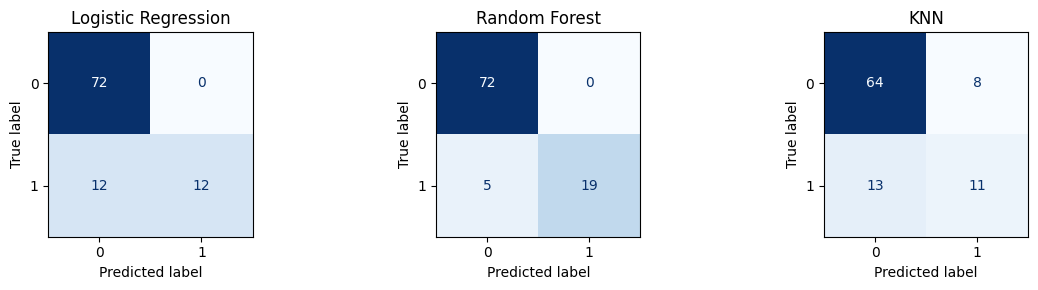

In [15]:
# Confusion Matrices
models = {"Logistic Regression": clf_log, "Random Forest": clf_rf, "KNN": clf_knn}
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [16]:
# Regression for known salaries
features = ['job_title', 'company_name', 'industry', 'seniority', 'job_state']
df_train_reg = df_combined[df_combined['avg_salary'].notnull()].copy()
X_rf = pd.get_dummies(df_train_reg[features].fillna("missing"))
X_rf = pd.concat([X_rf, df_train_reg[[c for c in df_combined.columns if c.startswith("tfidf_")]]], axis=1)
y_rf = df_train_reg['avg_salary']
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_rf, y_rf)


In [17]:
# Predict for missing
df_missing_rows = df_combined[df_combined['avg_salary'].isnull()].copy()
X_missing_rf = pd.get_dummies(df_missing_rows[features].fillna("missing"))
X_missing_rf = pd.concat([X_missing_rf, df_missing_rows[[c for c in df_combined.columns if c.startswith("tfidf_")]]], axis=1)
X_missing_rf = X_missing_rf.reindex(columns=X_rf.columns, fill_value=0)

predicted_salaries = reg_rf.predict(X_missing_rf)


In [18]:
# Save to dataframe
df_combined.loc[df_combined['was_missing'], 'avg_salary_predicted'] = predicted_salaries
df_combined['final_salary'] = df_combined['avg_salary']
df_combined.loc[df_combined['final_salary'].isnull(), 'final_salary'] = df_combined['avg_salary_predicted']


In [19]:
# Evaluation for regressor
print("\nRandom Forest Regressor Performance:")
print("MAE:", mean_absolute_error(y_rf, reg_rf.predict(X_rf)))
print("RMSE:", mean_squared_error(y_rf, reg_rf.predict(X_rf)) ** 0.5)
print("R² Score:", r2_score(y_rf, reg_rf.predict(X_rf)))


Random Forest Regressor Performance:
MAE: 4426.105121293801
RMSE: 7105.671655554446
R² Score: 0.9665126372932424


In [20]:
# LightGBM + Monotonic
features_lgbm = ['seniority_level', 'posting_age', 'job_state', 'industry', 'company_name', 'job_title']
df_lgbm = df_combined[df_combined['avg_salary'].notnull()].copy()
X_lgbm = pd.get_dummies(df_lgbm[features_lgbm].fillna("missing"))
X_lgbm['seniority_level'] = df_lgbm['seniority_level']
y_lgbm = df_lgbm['avg_salary']

In [21]:
# Sanitize column names
def sanitize_and_dedup_columns(df):
    df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
    seen = {}
    new_cols = []
    for col in df.columns:
        if col not in seen:
            seen[col] = 1
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
    df.columns = new_cols
    return df

In [22]:
X_lgbm = sanitize_and_dedup_columns(X_lgbm)
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = train_test_split(X_lgbm, y_lgbm, test_size=0.1, random_state=42)
monotonic_constraints = [1 if col == 'seniority_level' else 0 for col in X_train_lgbm.columns]

model_lgbm = LGBMRegressor(monotone_constraints=monotonic_constraints, n_estimators=100, random_state=42)
model_lgbm.fit(X_train_lgbm, y_train_lgbm)
y_pred_lgbm = model_lgbm.predict(X_test_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 667, number of used features: 24
[LightGBM] [Info] Start training from score 99610.944528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [23]:
# Evaluation
print("\n💡 LightGBM Monotonic:")
print("MAE:", mean_absolute_error(y_test_lgbm, y_pred_lgbm))
print("RMSE:", mean_squared_error(y_test_lgbm, y_pred_lgbm) ** 0.5)
print("R²:", r2_score(y_test_lgbm, y_pred_lgbm))


💡 LightGBM Monotonic:
MAE: 26386.03678949911
RMSE: 33580.411263443624
R²: 0.30806925767913995



📊 Fairness Audit by State:
job_state
CO    132514.341198
CA    120466.769921
IL    119277.355099
MA    110047.956328
FL    102421.732566
NC     98955.582933
WI     98920.739869
TN     97883.080169
PA     97701.413608
VA     97124.582014
NY     97040.397002
MD     92651.852819
IN     89600.051582
MO     84521.889156
GA     82766.322370
CT     81937.556517
NJ     78994.533888
WA     77567.970174
Name: mean_prediction, dtype: float64


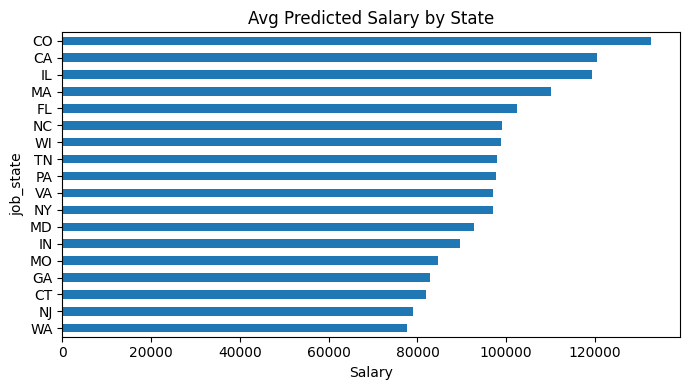

In [24]:
# Fairness audit
df_combined.loc[X_test_lgbm.index, 'lgbm_predicted'] = y_pred_lgbm
grouping_feature = df_combined.loc[X_test_lgbm.index, 'job_state']
mf = MetricFrame(metrics=mean_prediction,
                 y_true=df_combined.loc[X_test_lgbm.index, 'avg_salary'],
                 y_pred=df_combined.loc[X_test_lgbm.index, 'lgbm_predicted'],
                 sensitive_features=grouping_feature)

print("\n📊 Fairness Audit by State:")
print(mf.by_group.sort_values(ascending=False))
mf.by_group.sort_values().plot(kind='barh', figsize=(7, 4), title="Avg Predicted Salary by State")
plt.xlabel("Salary")
plt.tight_layout()
plt.show()

In [25]:
df_final = df_combined[[
    'job_title', 'salary_estimate','company_name', 'industry', 'sector', 'job_city', 'job_state',  'size',	'founded',	'type_of_ownership','revenue',	'seniority',
    'seniority_level','avg_salary', 'avg_salary_predicted',  'final_salary', 'was_missing'
]]
df_final.tail()

,job_title,salary_estimate,company_name,industry,sector,job_city,job_state,size,founded,type_of_ownership,revenue,seniority,seniority_level,avg_salary,avg_salary_predicted,final_salary,was_missing
951,Data Engineer 5 - Contract,-1,The Church of Jesus Christ of Latter-day Saint...,Religious Organizations,Non-Profit,Riverton,UT,10000+ employees,-1,Nonprofit Organization,Unknown / Non-Applicable,unknown,0,NaN,99325.0,99325.0,True
952,Data Scientists,-1,Miracle Software Systems\n3.3,IT Services,Information Technology,Michigan,Michigan,51 to 200 employees,1994,Company - Private,$50 to $100 million (USD),unknown,0,NaN,88345.0,88345.0,True
953,"Head Data Scientist – Image Analytics lead, No...",-1,Novartis\n3.8,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,Cambridge,MA,10000+ employees,1996,Company - Public,$10+ billion (USD),lead,4,NaN,114925.0,114925.0,True
954,"Scientist, Product Development",-1,Pharmavite\n2.9,Consumer Products Manufacturing,Manufacturing,Valencia,CA,1001 to 5000 employees,1971,Company - Private,$1 to $2 billion (USD),unknown,0,NaN,104775.0,104775.0,True
955,Data Engineer,-1,IGNW\n4.8,IT Services,Information Technology,Austin,TX,201 to 500 employees,2015,Company - Private,$25 to $50 million (USD),unknown,0,NaN,86235.0,86235.0,True


In [26]:
# Save df_selected to CSV
df_final.to_csv("df_final_output.csv", index=False)

# Download the file
from google.colab import files
files.download("df_final_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Create final_salary from available or predicted
#df_combined['final_salary'] = df_combined['avg_salary']
#df_combined.loc[df_combined['was_missing'], 'final_salary'] = df_combined.loc[df_combined['was_missing'], 'avg_salary_predicted']


In [28]:
# Just the rows where salary_estimate was originally missing
df_predicted_only = df_combined[df_combined['was_missing'] == True][[
    'job_title', 'company_name', 'salary_estimate' ,'final_salary'
]].reset_index(drop=True)

In [29]:
print("\n🟩 Predicted Missing Salary Rows:")
df_predicted_only.tail()


🟩 Predicted Missing Salary Rows:


,job_title,company_name,salary_estimate,final_salary
209,Data Engineer 5 - Contract,The Church of Jesus Christ of Latter-day Saint...,-1,99325.0
210,Data Scientists,Miracle Software Systems\n3.3,-1,88345.0
211,"Head Data Scientist – Image Analytics lead, No...",Novartis\n3.8,-1,114925.0
212,"Scientist, Product Development",Pharmavite\n2.9,-1,104775.0
213,Data Engineer,IGNW\n4.8,-1,86235.0


In [30]:
# Just the rows where salary_estimate was originally missing
df_predicted_only = df_combined[df_combined['was_missing'] == False][[
    'job_title', 'company_name', 'salary_estimate', 'final_salary'
]].reset_index(drop=True)

print("\n🟩 Available Salary Rows:")
df_predicted_only.head()


🟩 Available Salary Rows:


,job_title,company_name,salary_estimate,final_salary
0,Data Scientist,Tecolote Research\n3.8,$53K-$91K (Glassdoor est.),72000.0
1,Healthcare Data Scientist,University of Maryland Medical System\n3.4,$63K-$112K (Glassdoor est.),87500.0
2,Data Scientist,KnowBe4\n4.8,$80K-$90K (Glassdoor est.),85000.0
3,Data Scientist,PNNL\n3.8,$56K-$97K (Glassdoor est.),76500.0
4,Data Scientist,Affinity Solutions\n2.9,$86K-$143K (Glassdoor est.),114500.0


In [31]:
# Filter rows where salary was missing and is now predicted
df_present_screenshot = df_combined[df_combined['was_missing'] == 1][[
    'job_title',
    'company_name',
    'industry',
    'job_state',
    'job_city',
    'seniority_level',
    'salary_estimate',
    'final_salary',
    'was_missing'
]].reset_index(drop=True)

df_present_screenshot.head()  # or .to_csv() for export


,job_title,company_name,industry,job_state,job_city,seniority_level,salary_estimate,final_salary,was_missing
0,Data Scientist,Mars\n3.9,Food & Beverage Manufacturing,Oregon,Oregon,0,-1,114910.0,True
1,Data Scientist,Amount\n4.1,Enterprise Software & Network Solutions,IL,Chicago,0,-1,107440.0,True
2,Data Science Analyst,Brightside\n5.0,Investment Banking & Asset Management,AZ,Chandler,0,-1,105245.0,True
3,Data Engineer,Anson McCade\n4.5,Staffing & Outsourcing,IL,Kingdom,0,-1,86040.0,True
4,Business Intelligence Analyst,Amica Mutual\n3.1,Insurance Carriers,RI,Lincoln,0,-1,72105.0,True


In [32]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_present_screenshot)

https://docs.google.com/spreadsheets/d/1vIfM-1IGCUJwCk88gm8zSehThaazWO6jOgZCb-jDlEc/edit#gid=0


In [33]:
# Add avg_salary_predicted to show what the model predicted
df_present_technical = df_combined[df_combined['was_missing'] == 1][[
    'job_title',
    'company_name',
    'industry',
    'job_state',
    'salary_estimate',
    'avg_salary_predicted',
    'final_salary',
    'was_missing'
]].reset_index(drop=True)

df_present_technical.head()


,job_title,company_name,industry,job_state,salary_estimate,avg_salary_predicted,final_salary,was_missing
0,Data Scientist,Mars\n3.9,Food & Beverage Manufacturing,Oregon,-1,114910.0,114910.0,True
1,Data Scientist,Amount\n4.1,Enterprise Software & Network Solutions,IL,-1,107440.0,107440.0,True
2,Data Science Analyst,Brightside\n5.0,Investment Banking & Asset Management,AZ,-1,105245.0,105245.0,True
3,Data Engineer,Anson McCade\n4.5,Staffing & Outsourcing,IL,-1,86040.0,86040.0,True
4,Business Intelligence Analyst,Amica Mutual\n3.1,Insurance Carriers,RI,-1,72105.0,72105.0,True
